In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [75]:
KLKB1 = pd.read_csv('../dumps/KLKB1_processed.csv')
ST14 = pd.read_csv('../dumps/ST14_processed.csv')
TMPRSS6 = pd.read_csv('../dumps/TMPRSS6_processed.csv')
TMPRSS11D = pd.read_csv('../dumps/TMPRSS11D_processed.csv')

TMPRSS2 = pd.read_csv('../dumps/TMPRSS2_processed.csv')
pubchem_datasets = {'KLKB1':     KLKB1,
                    'ST13':      ST14,
                    'TMPRSS6':   TMPRSS6,
                    'TMPRSS11D': TMPRSS11D}

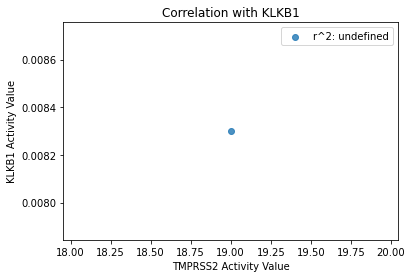

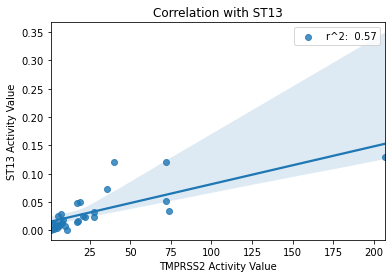

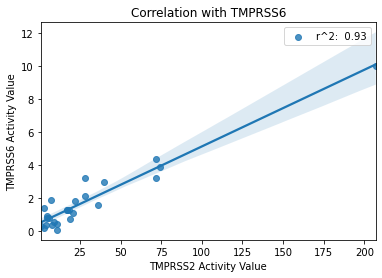

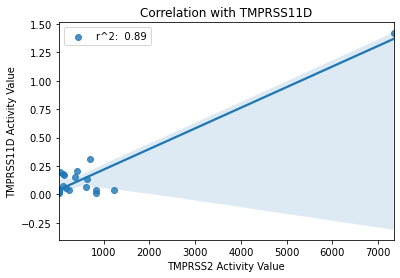

In [92]:
for name, pb_dataset in pubchem_datasets.items():
    plt.figure()
    overlap = pd.merge(TMPRSS2, pb_dataset, on=['cid', 'smiles'])
    x = overlap['acvalue_x']
    y = overlap['acvalue_y']
    try:
        sns.regplot(x, y, label=f'r^2: {pearsonr(x, y)[0]**2: .2f}')
    except ValueError:
        sns.regplot(x, y, label=f'r^2: undefined')
    plt.legend()
    plt.xlabel('TMPRSS2 Activity Value')
    plt.ylabel(f'{name} Activity Value')
    plt.title(f'Correlation with {name}')

From the above, it looks like we need 